<a href="https://colab.research.google.com/github/LKoech/ML-Progress-Learning/blob/main/HotDogOrNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds


## Citation

```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteX4T5FI/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteX4T5FI/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

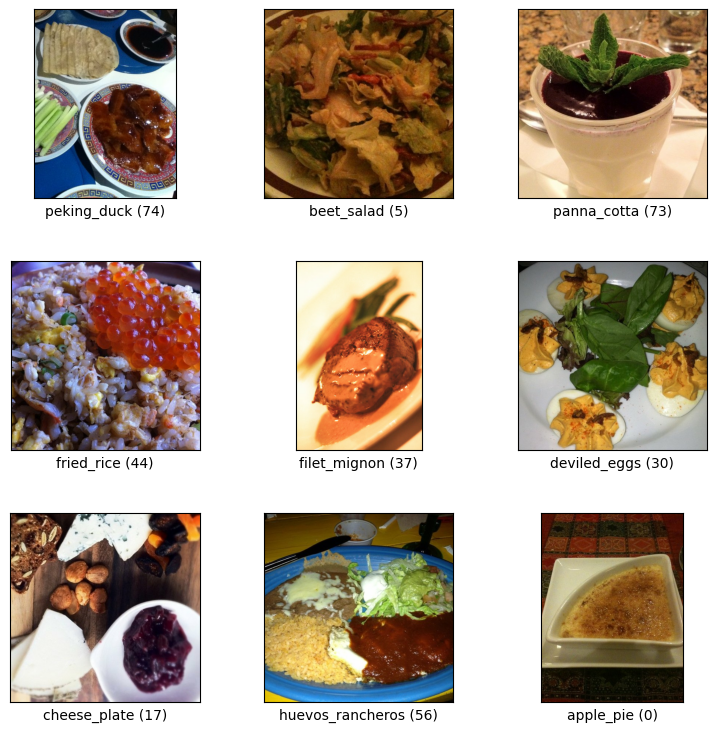

In [ ]:
fig = tfds.show_examples(train_ds,ds_info)

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

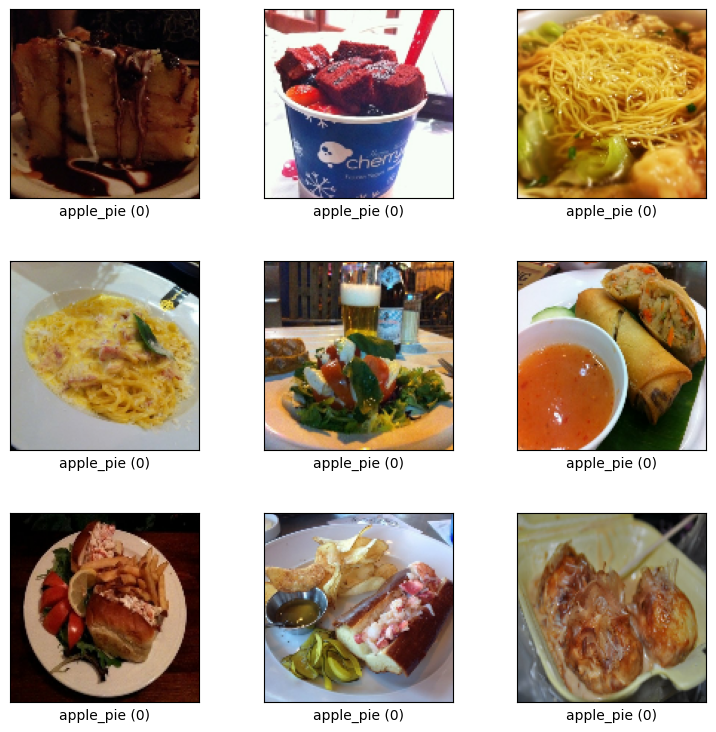

In [ ]:
fig = tfds.show_examples(train_ds,ds_info)

In [ ]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch,label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)


tf.Tensor(
[[[[226 226 177]
   [228 228 175]
   [224 226 170]
   ...
   [241 239 199]
   [240 233 200]
   [233 236 205]]

  [[220 221 162]
   [220 220 168]
   [218 219 162]
   ...
   [235 239 196]
   [240 236 201]
   [235 237 206]]

  [[214 216 156]
   [212 210 169]
   [211 210 161]
   ...
   [234 239 199]
   [239 237 206]
   [234 234 206]]

  ...

  [[132 115  72]
   [126 112  70]
   [167 159 117]
   ...
   [241 242 226]
   [242 243 227]
   [242 243 227]]

  [[129 110  70]
   [126 107  66]
   [133 119  76]
   ...
   [243 244 226]
   [243 244 226]
   [243 244 226]]

  [[134 112  75]
   [126 102  64]
   [124 106  66]
   ...
   [245 247 226]
   [243 245 224]
   [240 242 221]]]


 [[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]


NEURAL NETWORK IMPLEMENTATION

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for i,_ in ds["train"].take(1):
  image = i

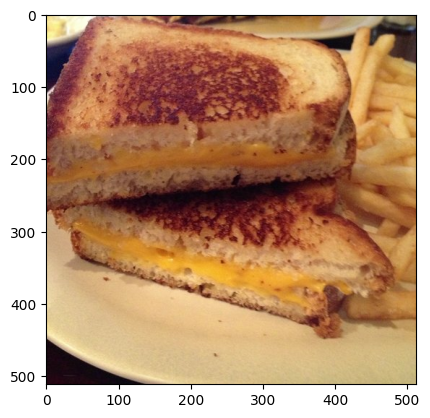

In [ ]:
plt.imshow(image)

In [ ]:
image =  tf.cast(tf.expand_dims(image,0),tf.float32)
image /= 255.0

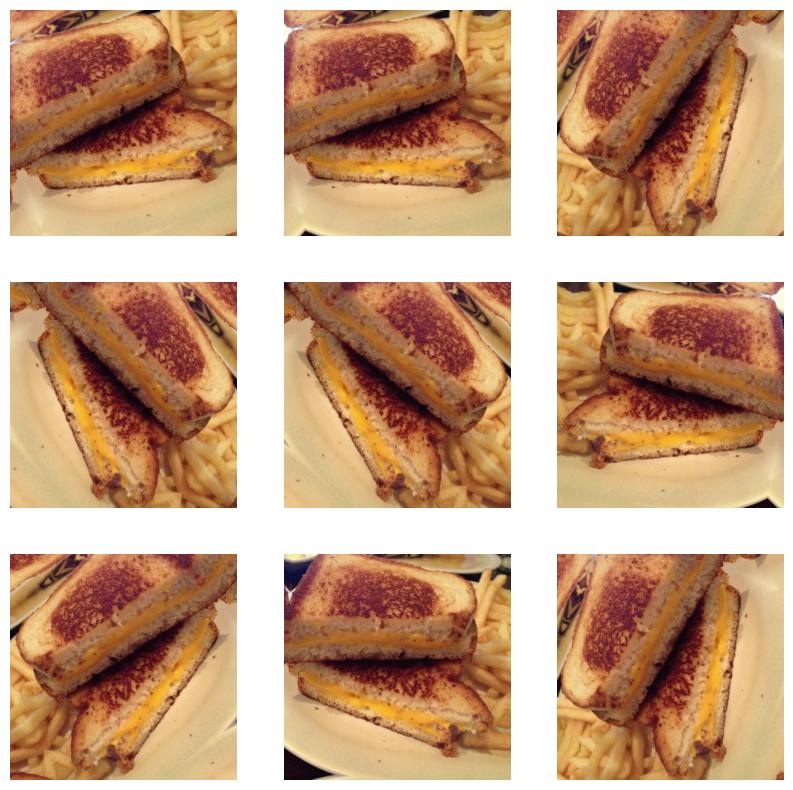

In [ ]:
plt.figure(figsize = (10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax =plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [ ]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
285/285 [==============================] - 1065s 4s/step - loss: 1.5158 - accuracy: 0.5106 - val_loss: 1.1770 - val_accuracy: 0.5007
Epoch 2/50
285/285 [==============================] - 475s 2s/step - loss: 1.0224 - accuracy: 0.5289 - val_loss: 0.9069 - val_accuracy: 0.5033
Epoch 3/50
285/285 [==============================] - 471s 2s/step - loss: 0.8513 - accuracy: 0.5365 - val_loss: 0.8020 - val_accuracy: 0.5346
Epoch 4/50
285/285 [==============================] - 470s 2s/step - loss: 0.7804 - accuracy: 0.5512 - val_loss: 0.7558 - val_accuracy: 0.5300
Epoch 5/50
285/285 [==============================] - 483s 2s/step - loss: 0.7408 - accuracy: 0.5679 - val_loss: 0.7248 - val_accuracy: 0.5606
Epoch 6/50
285/285 [==============================] - 475s 2s/step - loss: 0.7168 - accuracy: 0.5826 - val_loss: 0.7026 - val_accuracy: 0.5699
Epoch 7/50
285/285 [==============================] - 464s 2s/step - loss: 0.7016 - accuracy: 0.5872 - val_loss: 0.6881 - val_accuracy: 0.559

In [ ]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  label = label_batch


In [ ]:
for i in range(9):
  augmented_image = data_augmentation(image)
  ax =plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")